In [1]:
import os

# %cd /content/
# !ls -R
# repo_name = "ManualWarehouseOptimization"
# #!rm -rf {repo_name}
# if not os.path.exists(repo_name):
#     print(f"Directory {repo_name} does not exist, proceeding with clone.")
#     !git clone https://github.com/Abudo-S/ManualWarehouseOptimization.git

# %cd ManualWarehouseOptimization


In [2]:
import subprocess
import sys

#manual installing
def install_package(package_name, use_index_url=True):
    print(f"Installing {package_name}...")
    #run: python.exe -m pip install [package_name]

    subprocess.run(
        [sys.executable, "-m", "pip", "uninstall", "-y", package_name],
        check=True,
        text=True
    )
    if use_index_url:
        subprocess.run(
            [sys.executable, "-m", "pip", "install", package_name, "--index-url", "https://download.pytorch.org/whl/cu126"],
            check=True,
            text=True
        )
    else:
        subprocess.run(
            [sys.executable, "-m", "pip", "install", package_name],
            check=True,
            text=True
        )
    print(f"Successfully installed {package_name}!")

# Try to import, if it fails, install it
# try:
#     import torch
#     print("Torch is already available.")
# except:
#     #install_package('torch')
#     # After installing, you must use importlib to refresh or restart the script
#     import torch
#     print("Torch imported successfully after installation.")

#torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib
#torch-scatter torch-sparse torch-cluster torch-spline-conv
# install_package('torch-scatter')
# install_package('torch-sparse')
# install_package('torch-cluster')
# install_package('torch-spline-conv')

#Try to import, if it fails, install it
try:
    import k_means_constrained
    print("k_means_constrained is already available.")
except:
    install_package('k_means_constrained', False)
    # After installing, you must use importlib to refresh or restart the script
    import torch
    print("k_means_constrained imported successfully after installation.")

try:
    import torch_geometric
    print("torch_geometric is already available.")
except:
    install_package('torch_geometric', False)
    # After installing, you must use importlib to refresh or restart the script
    import torch
    print("torch_geometric imported successfully after installation.")

# %pip uninstall numpy -y
# %pip install numpy

k_means_constrained is already available.


c:\Users\abudo\source\vscode_projects\ManualWarehouseOptimization\cplex_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch_geometric is already available.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, BisectingKMeans
import importlib
import math
import os
from collections import defaultdict
import torch
from torch.utils.data import Dataset
from k_means_constrained import KMeansConstrained
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
%matplotlib inline
import GnnScheduleDataset as GnnScheduleDataset_Module
import MultiCriteriaGNNModel as MultiCriteriaGNNModel_Module
import ScheduleEvaluator as ScheduleEvaluator_Module

importlib.reload(GnnScheduleDataset_Module) # in case of updates
importlib.reload(MultiCriteriaGNNModel_Module) # in case of updates
importlib.reload(ScheduleEvaluator_Module) # in case of updates

from GnnScheduleDataset import GnnScheduleDataset
from MultiCriteriaGNNModel import MultiCriteriaGNNModel
from ScheduleEvaluator import ScheduleEvaluator


#file paths
LARGE_SCALE_BATCH_NAME = "Batch9000M" #Batch1000M
TARGET_MINI_BATCH_SIZE = 10 #number of missions per mini-batch
LARGE_SCALE_MISSION_BATCH_DIR = f"./datasets/{LARGE_SCALE_BATCH_NAME}.csv"
PREPROCESSED_BATCH_DIR = f"./preprocessed/{LARGE_SCALE_BATCH_NAME}/Batch{TARGET_MINI_BATCH_SIZE}M_idx.xlsx" #idx to be replaced cluster idx
MISSION_BATCH_DIR = f"./datasets/{LARGE_SCALE_BATCH_NAME}/mini-batch/Batch10M_distanced.csv"
UDC_TYPES_DIR = "./datasets/WM_UDC_TYPE.csv"
MISSION_BATCH_TRAVEL_DIR = f"./datasets/{LARGE_SCALE_BATCH_NAME}/mini-batch/Batch10M_travel_distanced.csv"
FORK_LIFTS_DIR = "./datasets/ForkLifts10W.csv"
#MISSION_TYPES_DIR = "./datasets/MissionTypes.csv"
SCHEDULE_DIR = f"./schedules/{LARGE_SCALE_BATCH_NAME}/mini-batch/"
NUM_EPOCHS = 10
BATCH_SIZE = 16 #nice to be equal to 32 or 64 since we have small mini-batch instances
LEARNING_RATE = 0.001


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

### Preprocessing
Split the large-scale batch in mini-batches (ex. 10 missions each) using spatial k-means, considering only `FROM_X, FROM_Y, FROM_Z, TO_X, TO_Y, TO_Z`.

In [5]:
def create_spatial_batches_and_save(input_csv=LARGE_SCALE_MISSION_BATCH_DIR, target_mini_batch_size=TARGET_MINI_BATCH_SIZE):
    """
    groups missions into spatially dense clusters of <50 missions
    and saves each group to a separate CSV file.
    """
    os.makedirs(os.path.dirname(PREPROCESSED_BATCH_DIR), exist_ok=True)

    #load the main dataset
    df = pd.read_csv(input_csv).drop_duplicates(subset=['CD_MISSION'], keep='first')
    df = df.reset_index(drop=True)
    n_samples = len(df)

    #determine number of clusters
    n_clusters = max(1, math.ceil(n_samples / target_mini_batch_size))
    print(f"total orders: {n_samples} | target clusters: {n_clusters}")

    if n_clusters == 1:
        df['cluster_id'] = 0
        df.to_csv('cluster_0.csv', index=False)
        return ["cluster_0.csv"]

    #feature Selection: 6D spatial coordinates
    #use both pickup (from) and drop-off (to) locations
    coord_cols = ['FROM_X', 'FROM_Y', 'FROM_Z', 'TO_X', 'TO_Y', 'TO_Z']

    for col in coord_cols:
        if df[col].dtype == 'object' or df[col].dtype == 'string':  #only apply to string/object columns
            df[col] = df[col].str.replace(',', '', regex=False)

    coords = df[coord_cols].astype(float).fillna(0).values

    #standardize (crucial for K-Means distance calculations)
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords)

    #cluster logic
    if n_clusters > 1:
        print(f"Starting constrained k-means clustering for {n_samples} samples into {n_clusters} clusters...")
        #kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) #produces some very unbalanced clusters
        #df['cluster_id'] = kmeans.fit_predict(coords_scaled)

        clf = KMeansConstrained(
            n_clusters=n_clusters,
            size_min=target_mini_batch_size - 1,
            size_max=target_mini_batch_size + 1,
            random_state=42,
            verbose=True, #print iteration updates to stdout
            #n_init=1, #run once instead of 10 times 
            n_jobs=-1  #use all cores for the 10 initializations
        )
        df['cluster_id'] = clf.fit_predict(coords_scaled)

        # model = BisectingKMeans(n_clusters=n_clusters, random_state=42, bisecting_strategy='largest_cluster')
        # df['cluster_id'] = model.fit_predict(coords_scaled)
    else:
        df['cluster_id'] = 0

    #save each cluster to its own file with original coordinates
    saved_files = []
    for cid in sorted(df['cluster_id'].unique()):
        cluster_df = df[df['cluster_id'] == cid].copy()

        #remove the temporary cluster_id before saving if desired
        cluster_df = cluster_df.drop(columns=['cluster_id'])

        file_name = PREPROCESSED_BATCH_DIR.replace("idx", str(cid+1))
        if file_name.endswith('.csv'):
            cluster_df.to_csv(file_name, index=False)
        else:
            cluster_df.to_excel(file_name, index=False)

        saved_files.append(file_name)

        print(f"saved {file_name} with {len(cluster_df)} missions.")

    return saved_files

create_spatial_batches_and_save()

total orders: 7992 | target clusters: 800
Starting constrained k-means clustering for 7992 samples into 800 clusters...
saved ./preprocessed/Batch9000M/Batch10M_1.xlsx with 11 missions.
saved ./preprocessed/Batch9000M/Batch10M_2.xlsx with 9 missions.
saved ./preprocessed/Batch9000M/Batch10M_3.xlsx with 11 missions.
saved ./preprocessed/Batch9000M/Batch10M_4.xlsx with 11 missions.
saved ./preprocessed/Batch9000M/Batch10M_5.xlsx with 9 missions.
saved ./preprocessed/Batch9000M/Batch10M_6.xlsx with 11 missions.
saved ./preprocessed/Batch9000M/Batch10M_7.xlsx with 11 missions.
saved ./preprocessed/Batch9000M/Batch10M_8.xlsx with 9 missions.
saved ./preprocessed/Batch9000M/Batch10M_9.xlsx with 11 missions.
saved ./preprocessed/Batch9000M/Batch10M_10.xlsx with 9 missions.
saved ./preprocessed/Batch9000M/Batch10M_11.xlsx with 9 missions.
saved ./preprocessed/Batch9000M/Batch10M_12.xlsx with 11 missions.
saved ./preprocessed/Batch9000M/Batch10M_13.xlsx with 11 missions.
saved ./preprocessed/Ba

['./preprocessed/Batch9000M/Batch10M_1.xlsx',
 './preprocessed/Batch9000M/Batch10M_2.xlsx',
 './preprocessed/Batch9000M/Batch10M_3.xlsx',
 './preprocessed/Batch9000M/Batch10M_4.xlsx',
 './preprocessed/Batch9000M/Batch10M_5.xlsx',
 './preprocessed/Batch9000M/Batch10M_6.xlsx',
 './preprocessed/Batch9000M/Batch10M_7.xlsx',
 './preprocessed/Batch9000M/Batch10M_8.xlsx',
 './preprocessed/Batch9000M/Batch10M_9.xlsx',
 './preprocessed/Batch9000M/Batch10M_10.xlsx',
 './preprocessed/Batch9000M/Batch10M_11.xlsx',
 './preprocessed/Batch9000M/Batch10M_12.xlsx',
 './preprocessed/Batch9000M/Batch10M_13.xlsx',
 './preprocessed/Batch9000M/Batch10M_14.xlsx',
 './preprocessed/Batch9000M/Batch10M_15.xlsx',
 './preprocessed/Batch9000M/Batch10M_16.xlsx',
 './preprocessed/Batch9000M/Batch10M_17.xlsx',
 './preprocessed/Batch9000M/Batch10M_18.xlsx',
 './preprocessed/Batch9000M/Batch10M_19.xlsx',
 './preprocessed/Batch9000M/Batch10M_20.xlsx',
 './preprocessed/Batch9000M/Batch10M_21.xlsx',
 './preprocessed/Batch

### Loss Defination
The loss function is a Weighted Sum of Binary Cross-Entropy (BCE) Losses. We choose BCE since the MIP model provides a binary solution "Yes/No" for every decision (Operator A was used, Edge X was traversed), so its treated as a supervised binary classification problem at every decision point.


It combines three distinct error signals, each corresponding to one of the decision heads (Activation, Assignment, Sequence), and weighted by the problem parameters alpha and beta to reflect the business priorities.

$$L_{\text{total}} =  \alpha \cdot (L_{\text{assignment}} + L_{\text{sequence}}) + \beta \cdot L_{\text{activation}}$$

Loss components:

* Activation Loss ($\mathcal{L}_{activation}$):
    BCELoss between predicted probabilities $P(active)$ and ground truth labels (0 or 1), in order to learn which operators to turn on.

    Its weight is scaled by $\beta$ (the penalty for using an extra operator). If $\beta$ is high, the model is penalized heavily for activating unnecessary forklifts.

* Assignment Loss ($\mathcal{L}_{assignment}$):
    BCELoss between predicted $P(assign)$ and ground truth edges (1 if Op $i$ did Order $j$, else 0), in order to learn orders assignement.

    Its weight is scaled by $\alpha$ (proxy for makespan/efficiency).

* Sequence Loss ($\mathcal{L}_{sequence}$):
    BCELoss between predicted $P(sequence)$ and ground truth transitions (1 if Order $j$ immediately follows Order $i$), In order to learn the sequencing of tasks.

    Its weight is also scaled by $\alpha$, as better sequencing directly reduces travel time.

Since we have considered a weighted loss function, the backward step propagated the participant heads w.r.t. their weight in the weighted loss. Nevertheless, the gradient conflict is a real issue, in which a head might require an optimization step on the opposite direction of the overwhelming optimization direction:

If $\nabla L_{\text{act}}$ and $\nabla L_{\text{assign}}$ point in opposite directions on shared weights $\theta_{\text{shared}}$, the update rule:
$$\theta_{\text{shared}} \leftarrow \theta_{\text{shared}} - \eta \left( \beta \nabla_{\theta} L_{\text{act}} + \alpha \nabla_{\theta} L_{\text{assign}} \right)$$

can result in partial cancellation if:
$$\cos(\phi) = \frac{\nabla L_{\text{act}} \cdot \nabla L_{\text{assign}}}{\|\nabla L_{\text{act}}\| \|\nabla L_{\text{assign}}\|} < 0$$


To have more control on the loss effectiveness over heads, we'd adopt a **separate optimizer for each head**, while the global loss weight ($\alpha, \beta$) scales the gradient magnitude passed to the shared trunk. Separate optimizers allow us to scale the update step size (learning rate) for each head independently. This is particularly useful if one task (e.g., Sequencing) is much harder to learn or requires a different convergence speed than another (e.g., Activation). We need to have a seperation strategy as the following:  
1. Parameters partitioning: Split the model into the shared "trunk" (GNN layers) and the individual "heads" (MLP layers).
2. Separate optimizers initialization: Assign different learning rates (LR) or even different algorithms (Adam vs SGD) to each optimizer based on the observed learning curve per head/task.
3. Single training loop: All optimizers should work on the same number of epochs in the training loop. So the backward pass remains largely the same (a single global graph), but the updates are decoupled. A backward step could be freezed (by not calling it) per any optimizer in case of necessity.

Real examples of our GNN heads separated optimizers:  
* Fast learning: If **activation** is easy and learns instantly, its large gradients might distort the GNN embeddings early on. We can set the relative **learning rate** to be very low (or 0) for the first few epochs ("Warm-up").
* Lazy learning:  If **Sequence** loss is small (due to low $\alpha$) but we want the head to learn faster, we can increase the relative **learning rate**. This will boost the head's adaptation without forcing us to increase $\alpha$ (which would destabilize the trunk).

### Performance Plot (Loss & Accuracy)

In [6]:
'''
model_evaluation should contain loss, val_loss, accuracy, val_accuracy
'''
def performance_plot(model_evaluation:dict, title='Model Performance', ignore_accuracy_plot=False):
    plt.clf()
    plt.figure(figsize=(16, 6))

    if not ignore_accuracy_plot:
        plt.subplot(1, 2, 1)

    #plot loss
    plt.plot(model_evaluation['train_loss'])
    plt.plot(model_evaluation['val_loss'])
    plt.ylabel('Loss', size=12)
    plt.xlabel('Epoch', size=12)
    plt.legend(['training', 'validation'])

    #plot accuracy score
    if not ignore_accuracy_plot:
        plt.subplot(1, 2, 2)
        plt.plot(model_evaluation['train_accuracy'])
        plt.plot(model_evaluation['val_accuracy'])
        plt.ylabel('Accuracy', size=12)
        plt.xlabel('Epoch', size=12)
        plt.legend(['training', 'validation'])

    plt.suptitle(title, size=16, fontweight='bold')
    plt.show()

### Batch Size for Data Loading
Here we're refering to the `batch_size` which is the number if graphs to be passed together to the GNN model, for which the optimization and back-propagation steps are calculated. Generally it's prefered to use `batch_size` > 1 for these reasons:  
* Gradient Stability: A single graph might represent a very "easy" or very "hard" scheduling instance. Hence, updating the model based on single graphs makes the gradients biased to these single instances noisy and erratic ("stochastic" gradient descent), so the GNN model would become biased to these single instances. Averaging the loss over 4, 8, or 32 graphs creates a smoother, more reliable signal ("mini-batch" gradient descent), so the GNN model would become more generalizzed and unbiased.
* Hardware Efficiency: GPUs are designed for parallel processing. Processing 1 graph at a time leaves the GPU mostly idle, so it'll be convenient to proces multiple graphs at the same time.

Note that: In `PyTorch Geometric (PyG)`, "Batch Size 32" doesn't mean a tensor of shape `(32, N, F)`.
Instead, it creates one giant disjoint graph containing all 32 individual graphs combined (e.g. A graph instance contains 500 nodes, a 32-batch will be 32 x 500 = 16K nodes!), which might cause an `Out Of Memory (OOM) error` on the GPU if we don't have enough memory to elaborate such a mega instance at once.  
So we can choose the `batch_size` considering the size of our single examples as the following:  
- Small graphs (< 500 nodes) **like our case**: Use batch_size=32 or 64.
- Medium graphs (500-2000 nodes): Use batch_size=8 or 16.
- Large graphs (> 5000 nodes): We might be forced to use batch_size=1 or 2.

Since `batch_size` is considered a hyperparameter that determines the speed of training and the quality of the model (it affects the gradient estimation; therefore, the loss calculation), the correct approach to determine its exact and appropriate value would be hyperparmeter tuning.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#init dataset
dataset = GnnScheduleDataset(
    schedule_dir=SCHEDULE_DIR,
    mission_base_path=MISSION_BATCH_DIR,
    edge_base_path=MISSION_BATCH_TRAVEL_DIR,
    pallet_types_file_path=UDC_TYPES_DIR,
    fork_path=FORK_LIFTS_DIR
)

print(f"found {len(dataset)} valid schedule instances.")

#init model
if len(dataset) > 0:
    sample_data = dataset[0]
    model = MultiCriteriaGNNModel(
        metadata=sample_data.metadata(),
        hidden_dim=64,
        num_layers=3,
        heads=4
    ).to(device)

    schedule_evaluator = ScheduleEvaluator(model=model,
                                           schedule_dataset=dataset,
                                           batch_size=BATCH_SIZE)

    #create dataLoader using the training dataset
    #batch_size can be > 1 to train on multiple graphs at once
    loader = DataLoader(schedule_evaluator.schedule_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    print(f"DataLoader created with {len(loader)} batches of size {BATCH_SIZE}.")

Using device: cuda
found 92 valid schedule instances.
Using device: cuda
First element of the schedule training set: HeteroData(
  u=[1, 3],
  order={
    x=[10, 10],
    global_id=[10],
  },
  operator={
    x=[10, 7],
    global_id=[10],
    y=[10],
  },
  (order, to, order)={
    edge_index=[2, 90],
    edge_attr=[90, 1],
    y=[90],
  },
  (operator, assign, order)={
    edge_index=[2, 100],
    edge_attr=[100, 1],
    y=[100],
  },
  (order, rev_assign, operator)={
    edge_index=[2, 100],
    edge_attr=[100, 1],
  }
)
First element of the schedule test set: HeteroData(
  u=[1, 3],
  order={
    x=[9, 10],
    global_id=[9],
  },
  operator={
    x=[10, 7],
    global_id=[10],
    y=[10],
  },
  (order, to, order)={
    edge_index=[2, 72],
    edge_attr=[72, 1],
    y=[72],
  },
  (operator, assign, order)={
    edge_index=[2, 90],
    edge_attr=[90, 1],
    y=[90],
  },
  (order, rev_assign, operator)={
    edge_index=[2, 90],
    edge_attr=[90, 1],
  }
)
DataLoader created with 

### Single Optimizer for all Task Heads

epoch 1/10:   0%|          | 0/5 [00:00<?, ?it/s]

epoch 1/10: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


(act_loss: 0.542, assign_loss: 0.137, seq_loss: 0.341)
(act_acc: 0.759, assign_acc: 0.969, seq_acc: 0.903)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


[Epoch 1]: Training Loss: 0.5587329268455505, Validation Loss: 0.5608475804328918


epoch 2/10: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


(act_loss: 0.538, assign_loss: 0.136, seq_loss: 0.331)
(act_acc: 0.759, assign_acc: 0.969, seq_acc: 0.902)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


[Epoch 2]: Training Loss: 0.5300626158714294, Validation Loss: 0.5420963764190674


epoch 3/10: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


(act_loss: 0.532, assign_loss: 0.136, seq_loss: 0.323)
(act_acc: 0.759, assign_acc: 0.969, seq_acc: 0.903)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


[Epoch 3]: Training Loss: 0.5199785232543945, Validation Loss: 0.5492967367172241


epoch 4/10: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


(act_loss: 0.532, assign_loss: 0.135, seq_loss: 0.321)
(act_acc: 0.759, assign_acc: 0.969, seq_acc: 0.902)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


[Epoch 4]: Training Loss: 0.527275562286377, Validation Loss: 0.5415470600128174


epoch 5/10: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


(act_loss: 0.531, assign_loss: 0.136, seq_loss: 0.319)
(act_acc: 0.757, assign_acc: 0.969, seq_acc: 0.903)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


[Epoch 5]: Training Loss: 0.6014642119407654, Validation Loss: 0.545058012008667


epoch 6/10: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


(act_loss: 0.531, assign_loss: 0.136, seq_loss: 0.321)
(act_acc: 0.758, assign_acc: 0.969, seq_acc: 0.902)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


[Epoch 6]: Training Loss: 0.5961032509803772, Validation Loss: 0.5426127910614014


epoch 7/10: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


(act_loss: 0.529, assign_loss: 0.135, seq_loss: 0.321)
(act_acc: 0.759, assign_acc: 0.969, seq_acc: 0.902)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


[Epoch 7]: Training Loss: 0.5389593839645386, Validation Loss: 0.5440276265144348


epoch 8/10: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


(act_loss: 0.528, assign_loss: 0.135, seq_loss: 0.320)
(act_acc: 0.759, assign_acc: 0.969, seq_acc: 0.902)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


[Epoch 8]: Training Loss: 0.510072648525238, Validation Loss: 0.5420088768005371


epoch 9/10: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


(act_loss: 0.530, assign_loss: 0.134, seq_loss: 0.322)
(act_acc: 0.760, assign_acc: 0.969, seq_acc: 0.901)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


[Epoch 9]: Training Loss: 0.5142526626586914, Validation Loss: 0.5461257696151733


epoch 10/10: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


(act_loss: 0.528, assign_loss: 0.135, seq_loss: 0.320)
(act_acc: 0.760, assign_acc: 0.969, seq_acc: 0.902)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

[Epoch 10]: Training Loss: 0.4978483319282532, Validation Loss: 0.5421299338340759
Cumulative confusion matrix: TN, FP, FN, TP
[[18170     0]
 [ 1410     0]]
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Support: 1410


<Figure size 640x480 with 0 Axes>

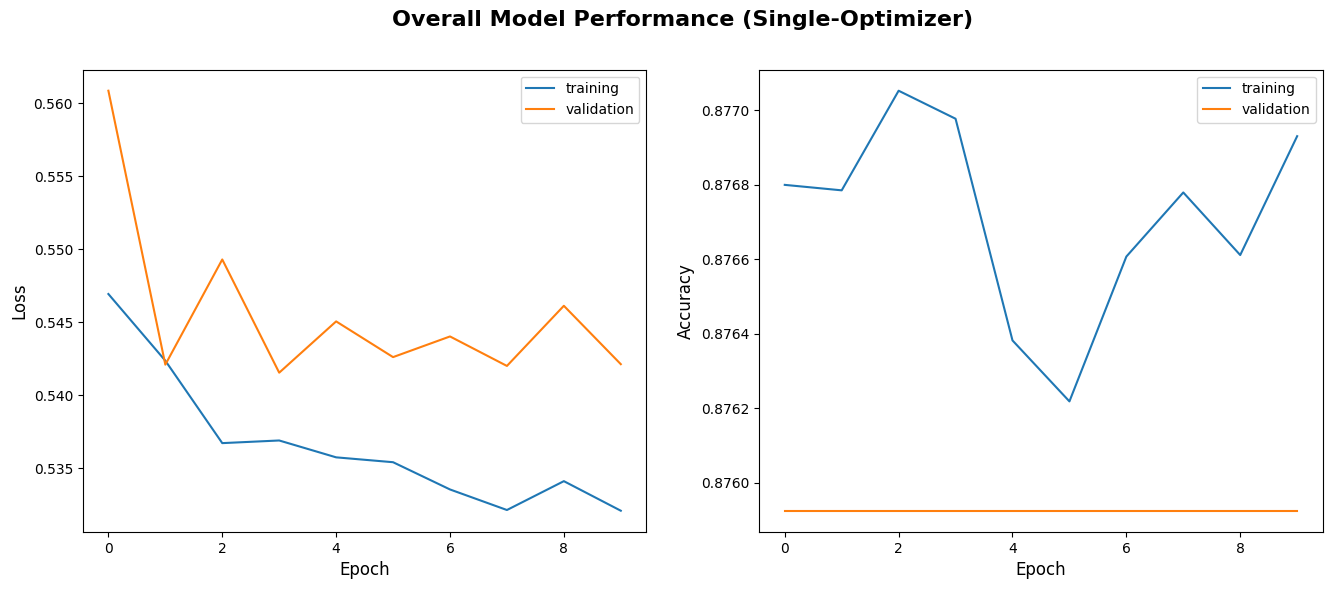

In [12]:
if len(dataset) > 0:

    #adam optimizer is a standard for GNNs
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    perfermace_records = defaultdict(list)
    activation_perfermace_records = defaultdict(list)
    assignment_perfermace_records = defaultdict(list)
    sequence_perfermace_records = defaultdict(list)
    cumulative_confusion_matrix = np.zeros((2, 2), dtype=int)

    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        total_epoch_loss = 0.0
        total_epoch_accuracy = 0.0

        #single heads performance
        total_epoch_activation_loss = 0.0
        total_epoch_assignment_loss = 0.0
        total_epoch_sequence_loss = 0.0
        total_epoch_activation_accuracy = 0.0
        total_epoch_assignment_accuracy = 0.0
        total_epoch_sequence_accuracy = 0.0

        for batch_idx, batch in tqdm(enumerate(loader), total=len(loader), desc=f"epoch {epoch}/{NUM_EPOCHS}"):
            batch = batch.to(device)
            optimizer.zero_grad()

            #construct batch_dict
            batch_dict_arg = {
                'operator': batch['operator'].batch,
                'order': batch['order'].batch
            }

            #forward pass
            preds = model(
                batch.x_dict,
                batch.edge_index_dict,
                batch.edge_attr_dict,
                batch.u,
                batch_dict=batch_dict_arg
            )

            #backward step and optimization
            loss, l_act, l_assign, l_seq = schedule_evaluator.weighted_loss(preds, batch, batch.u)
            measurements = schedule_evaluator.calculate_metrics(preds, batch)

            loss.backward()
            optimizer.step()

            #register losses
            total_epoch_loss += loss.item()
            total_epoch_activation_loss += l_act
            total_epoch_assignment_loss += l_assign
            total_epoch_sequence_loss += l_seq

            #register accuracies
            total_epoch_accuracy += sum([measurements['act_acc'], measurements['assign_acc'], measurements['seq_acc']]) / 3.0
            total_epoch_activation_accuracy += measurements['act_acc']
            total_epoch_assignment_accuracy += measurements['assign_acc']
            total_epoch_sequence_accuracy += measurements['seq_acc']

        avg_loss = total_epoch_loss / len(loader)
        avg_accuracy = total_epoch_accuracy / len(loader)

        #take loss means
        avg_loss = total_epoch_loss / len(loader)
        avg_act_loss = total_epoch_activation_loss / len(loader)
        avg_assign_loss = total_epoch_assignment_loss / len(loader)
        avg_seq_loss = total_epoch_sequence_loss / len(loader)

        #take accuracy means
        avg_accuracy = total_epoch_accuracy / len(loader)
        avg_act_accuracy = total_epoch_activation_accuracy / len(loader)
        avg_assign_accuracy = total_epoch_assignment_accuracy / len(loader)
        avg_seq_accuracy = total_epoch_sequence_accuracy / len(loader)


        #print(f"Epoch {epoch} complete. average loss: {avg_loss:.4f}")
        print(f"(act_loss: {avg_act_loss:.3f}, assign_loss: {avg_assign_loss:.3f}, seq_loss: {avg_seq_loss:.3f})")
        print(f"(act_acc: {avg_act_accuracy:.3f}, assign_acc: {avg_assign_accuracy:.3f}, seq_acc: {avg_seq_accuracy:.3f})")


        #append calculated training loss means
        perfermace_records['train_loss'].append(avg_loss)
        activation_perfermace_records['train_loss'].append(avg_act_loss)
        assignment_perfermace_records['train_loss'].append(avg_assign_loss)
        sequence_perfermace_records['train_loss'].append(avg_seq_loss)

        #append calculated training accuracy means
        perfermace_records['train_accuracy'].append(avg_accuracy)
        activation_perfermace_records['train_accuracy'].append(avg_act_accuracy)
        assignment_perfermace_records['train_accuracy'].append(avg_assign_accuracy)
        sequence_perfermace_records['train_accuracy'].append(avg_seq_accuracy)

        #validation step
        validation_performance = schedule_evaluator.evaluate()
        val_loss, val_accuracy = validation_performance['total_loss'], validation_performance['total_accuracy']
        act_loss, act_accuracy = validation_performance['act_loss'], validation_performance['act_accuracy']
        assign_loss, assign_accuracy = validation_performance['assign_loss'], validation_performance['assign_accuracy']
        seq_loss, seq_accuracy = validation_performance['seq_loss'], validation_performance['seq_accuracy']
        cumulative_confusion_matrix += validation_performance['total_cm']

        print(f"[Epoch {epoch}]: Training Loss: {loss.item()}, Validation Loss: {val_loss}")

        #append calculated validation loss means
        perfermace_records['val_loss'].append(val_loss)
        activation_perfermace_records['val_loss'].append(act_loss)
        assignment_perfermace_records['val_loss'].append(assign_loss)
        sequence_perfermace_records['val_loss'].append(seq_loss)

        #append calculated validation accuracy means
        perfermace_records['val_accuracy'].append(val_accuracy)
        activation_perfermace_records['val_accuracy'].append(act_accuracy)
        assignment_perfermace_records['val_accuracy'].append(assign_accuracy)
        sequence_perfermace_records['val_accuracy'].append(seq_accuracy)

        # print(f"Batch {batch_idx}:")
        # print(f"Batch Size: {batch.num_graphs}")
        # print(f"Activation Probs: {out['activation']}")
        # print(f"Assignment Probs: {out['assignment']}")
        # print(f"Sequence Probs: {out['sequence']}")

    print("Cumulative confusion matrix: TN, FP, FN, TP")
    print(cumulative_confusion_matrix)

    precision, recall, f1, support = schedule_evaluator.calculate_f1_metrics(cumulative_confusion_matrix)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Support: {support}")

    performance_plot(perfermace_records,'Overall Model Performance (Single-Optimizer)')

### Activation Head Performance (Single-Optimizer)

defaultdict(<class 'list'>, {'train_loss': [11.160135173797608, 1.621985912322998, 0.6710252642631531, 0.9420045375823974, 0.9639500141143799, 0.8690240144729614, 0.7278390049934387, 0.5997342348098755, 0.5516053557395935, 0.578438913822174], 'train_accuracy': [0.24125000000000002, 0.3255357142857143, 0.7591071428571429, 0.7598214285714285, 0.7589285714285714, 0.7592857142857142, 0.76, 0.7587499999999999, 0.7589285714285714, 0.7596428571428572], 'val_loss': [2.2429747581481934, 0.5410706996917725, 0.7689672112464905, 0.8523294925689697, 0.787778913974762, 0.6803184747695923, 0.5833539962768555, 0.5414296984672546, 0.5845564007759094, 0.5811224579811096], 'val_accuracy': [0.24285714285714285, 0.7571428571428571, 0.7571428571428571, 0.7571428571428571, 0.7571428571428571, 0.7571428571428571, 0.7571428571428571, 0.7571428571428571, 0.7571428571428571, 0.7571428571428571]})


<Figure size 640x480 with 0 Axes>

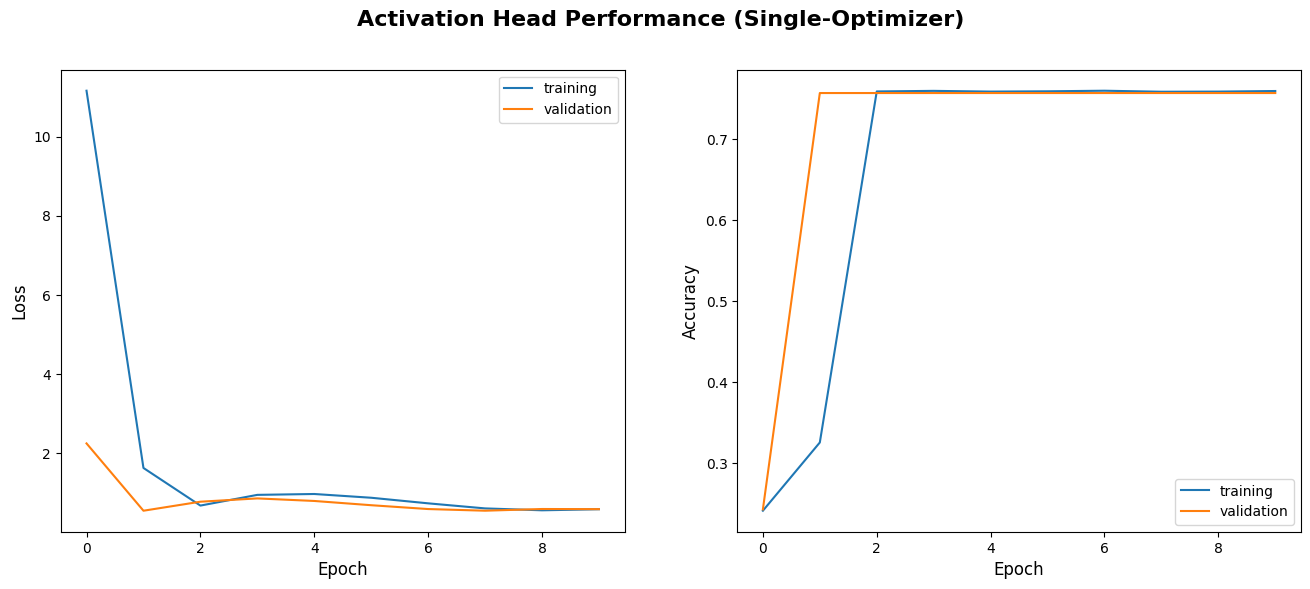

In [5]:
print(activation_perfermace_records)
performance_plot(activation_perfermace_records, title='Activation Head Performance (Single-Optimizer)')

### Assignment Head Performance (Single-Optimizer)

<Figure size 640x480 with 0 Axes>

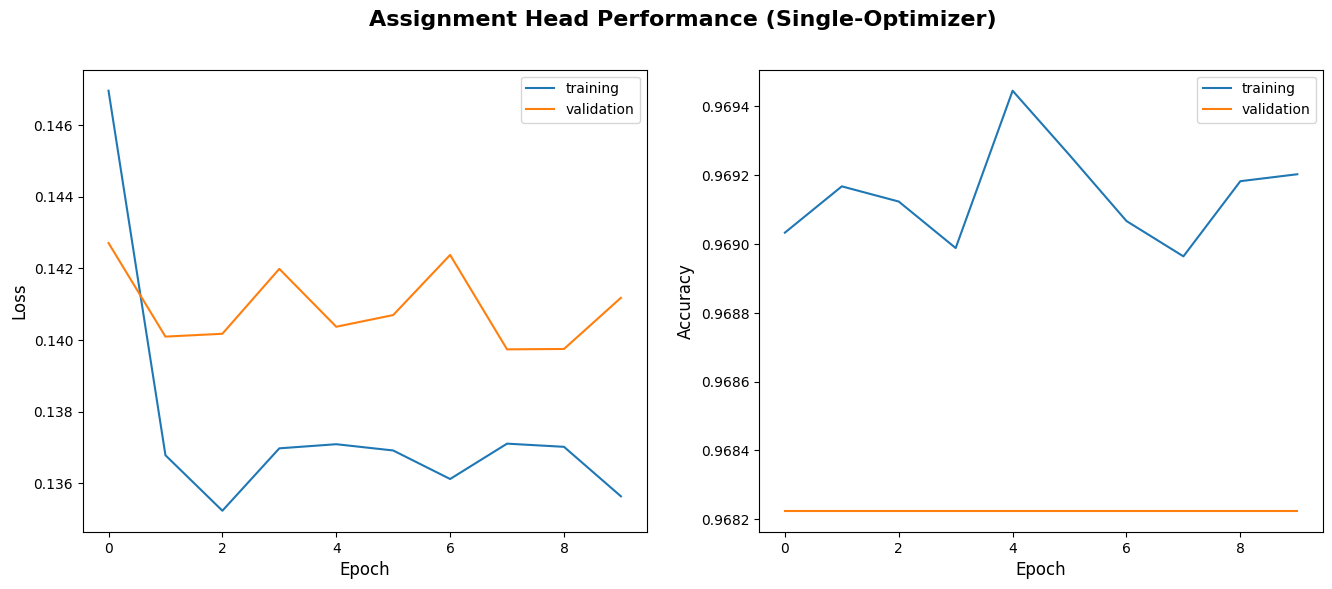

In [11]:
#print(assignment_perfermace_records)
performance_plot(assignment_perfermace_records, title='Assignment Head Performance (Single-Optimizer)')

### Sequencing Head Performance (Single-Optimizer)

<Figure size 640x480 with 0 Axes>

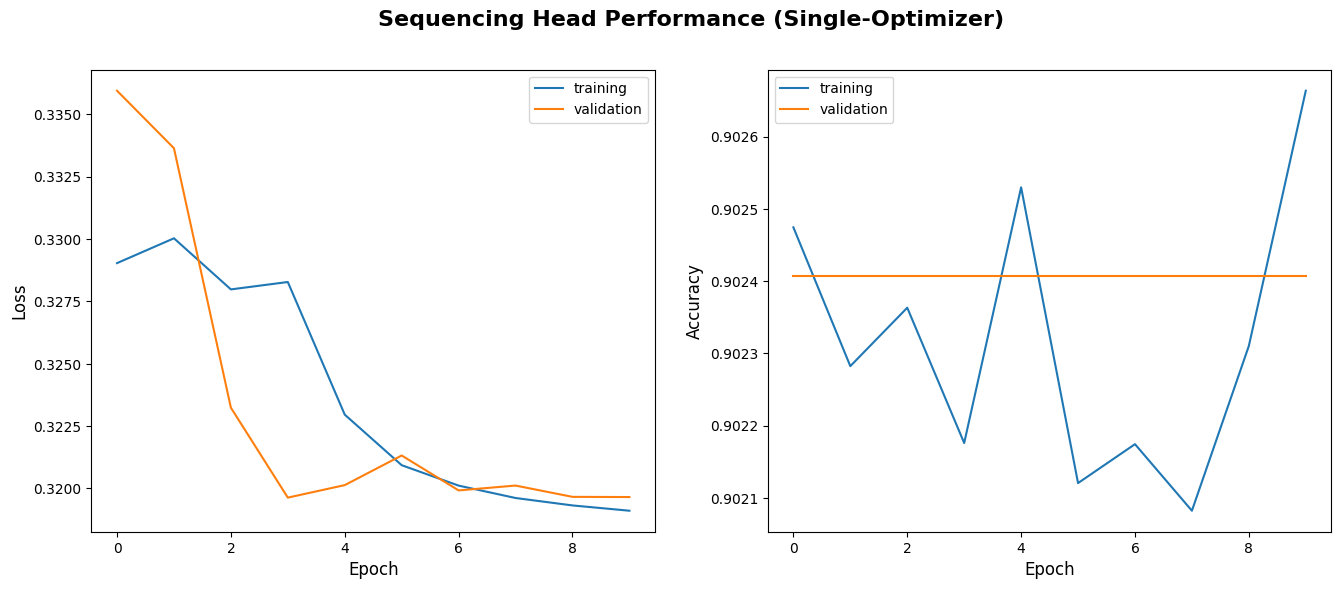

In [17]:
performance_plot(sequence_perfermace_records, title='Sequencing Head Performance (Single-Optimizer)')

### Separated Optimizer for Each Task Head

Trunk Params: 67
Activation Params: 4
Assignment Params: 4
Sequence Params: 4


epoch 1/10: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


(act_loss: 0.555, assign_loss: 0.136, seq_loss: 0.355)
(act_acc: 0.759, assign_acc: 0.969, seq_acc: 0.861)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


[Epoch 1]: Training Loss: 0.5952006578445435, Validation Loss: 0.5673784017562866


epoch 2/10: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


(act_loss: 0.545, assign_loss: 0.136, seq_loss: 0.370)
(act_acc: 0.759, assign_acc: 0.969, seq_acc: 0.902)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


[Epoch 2]: Training Loss: 0.5778790712356567, Validation Loss: 0.5441067218780518


epoch 3/10: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


(act_loss: 0.534, assign_loss: 0.136, seq_loss: 0.332)
(act_acc: 0.759, assign_acc: 0.969, seq_acc: 0.902)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


[Epoch 3]: Training Loss: 0.5307783484458923, Validation Loss: 0.5531917810440063


epoch 4/10: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


(act_loss: 0.531, assign_loss: 0.137, seq_loss: 0.327)
(act_acc: 0.759, assign_acc: 0.969, seq_acc: 0.903)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


[Epoch 4]: Training Loss: 0.5542527437210083, Validation Loss: 0.5414830446243286


epoch 5/10: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


(act_loss: 0.530, assign_loss: 0.136, seq_loss: 0.331)
(act_acc: 0.760, assign_acc: 0.969, seq_acc: 0.903)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


[Epoch 5]: Training Loss: 0.490097314119339, Validation Loss: 0.5444000959396362


epoch 6/10: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


(act_loss: 0.531, assign_loss: 0.136, seq_loss: 0.322)
(act_acc: 0.757, assign_acc: 0.969, seq_acc: 0.903)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


[Epoch 6]: Training Loss: 0.5902643203735352, Validation Loss: 0.5418893694877625


epoch 7/10: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


(act_loss: 0.529, assign_loss: 0.135, seq_loss: 0.322)
(act_acc: 0.760, assign_acc: 0.969, seq_acc: 0.902)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


[Epoch 7]: Training Loss: 0.5089338421821594, Validation Loss: 0.5436487793922424


epoch 8/10: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


(act_loss: 0.528, assign_loss: 0.134, seq_loss: 0.323)
(act_acc: 0.759, assign_acc: 0.969, seq_acc: 0.902)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


[Epoch 8]: Training Loss: 0.5311065912246704, Validation Loss: 0.5426018834114075


epoch 9/10: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


(act_loss: 0.528, assign_loss: 0.135, seq_loss: 0.321)
(act_acc: 0.759, assign_acc: 0.969, seq_acc: 0.902)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


[Epoch 9]: Training Loss: 0.5406018495559692, Validation Loss: 0.5426102876663208


epoch 10/10: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


(act_loss: 0.526, assign_loss: 0.134, seq_loss: 0.320)
(act_acc: 0.760, assign_acc: 0.969, seq_acc: 0.902)


Evaluating on test set: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

[Epoch 10]: Training Loss: 0.5000578761100769, Validation Loss: 0.5420989990234375
Cumulative confusion matrix: TN, FP, FN, TP
[[18170     0]
 [ 1410     0]]
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Support: 1410


<Figure size 640x480 with 0 Axes>

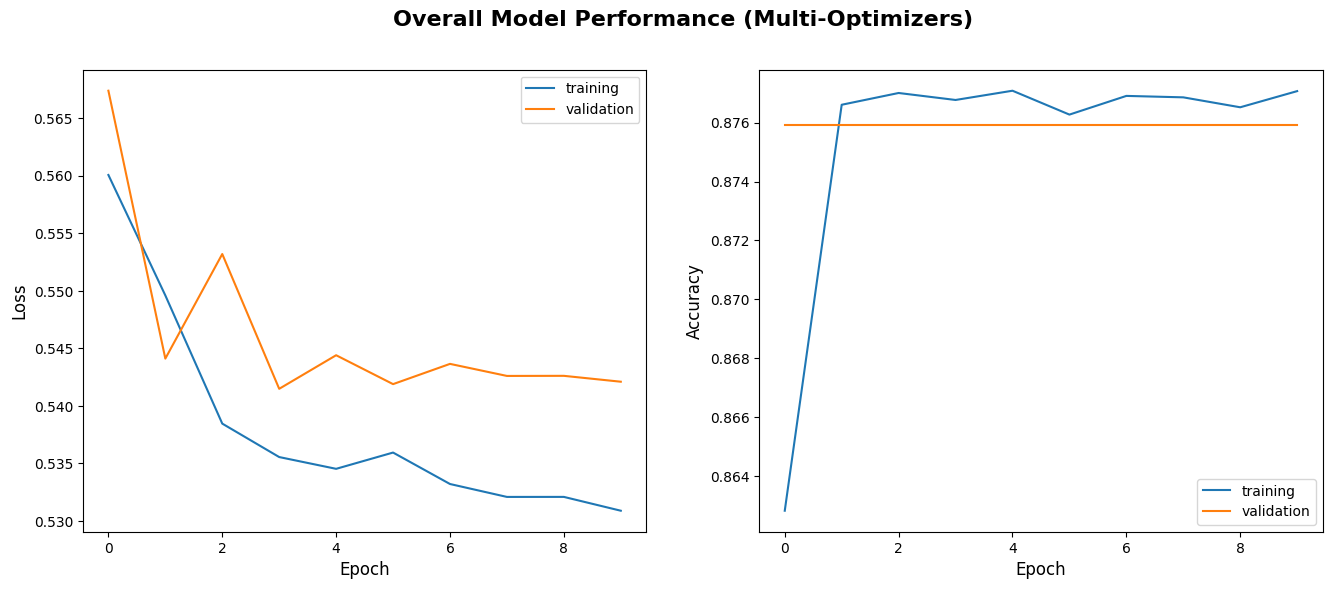

In [13]:
if len(dataset) > 0:

    #adam optimizer is a standard for GNNs
    #trunk includes the initial linear layers and the GNN message passing layers
    trunk_params = (
        list(model.order_lin.parameters()) +
        list(model.op_lin.parameters()) +
        list(model.convs.parameters())
    )

    #heads are already defined as sequential blocks in our model
    activation_params = list(model.activation_head.parameters())
    assignment_params = list(model.assign_head.parameters())
    sequence_params = list(model.seq_head.parameters())

    print(f"Trunk Params: {len(trunk_params)}")
    print(f"Activation Params: {len(activation_params)}")
    print(f"Assignment Params: {len(assignment_params)}")
    print(f"Sequence Params: {len(sequence_params)}")

    optimizers = []

    #it's possibile to experiment with different learning rates for each part, depending on task complexity and convergence behavior
    #trunk: base learning rate (affects everything)
    optimizers.append(torch.optim.Adam(trunk_params, lr=LEARNING_RATE))

    #activation: simple task? maybe lower lr or freeze it later
    optimizers.append(torch.optim.Adam(activation_params, lr=LEARNING_RATE))

    #assignment: standard lr
    optimizers.append(torch.optim.Adam(assignment_params, lr=LEARNING_RATE))

    #sequence: hard task? maybe higher lr or weight decay
    optimizers.append(torch.optim.Adam(sequence_params, lr=LEARNING_RATE))

    perfermace_records = defaultdict(list)
    activation_perfermace_records = defaultdict(list)
    assignment_perfermace_records = defaultdict(list)
    sequence_perfermace_records = defaultdict(list)
    cumulative_confusion_matrix = np.zeros((2, 2), dtype=int)

    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        total_epoch_loss = 0.0
        total_epoch_accuracy = 0.0

        #single heads performance
        total_epoch_activation_loss = 0.0
        total_epoch_assignment_loss = 0.0
        total_epoch_sequence_loss = 0.0
        total_epoch_activation_accuracy = 0.0
        total_epoch_assignment_accuracy = 0.0
        total_epoch_sequence_accuracy = 0.0


        for batch_idx, batch in tqdm(enumerate(loader), total=len(loader), desc=f"epoch {epoch}/{NUM_EPOCHS}"):
            batch = batch.to(device)

            for opt in optimizers:
                opt.zero_grad()

            #construct batch_dict
            batch_dict_arg = {
                'operator': batch['operator'].batch,
                'order': batch['order'].batch
            }

            #forward pass
            preds = model(
                batch.x_dict,
                batch.edge_index_dict,
                batch.edge_attr_dict,
                batch.u,
                batch_dict=batch_dict_arg
            )

            #backward step and optimization
            loss, l_act, l_assign, l_seq = schedule_evaluator.weighted_loss(preds, batch, batch.u)
            measurements = schedule_evaluator.calculate_metrics(preds, batch)

            #this fills .grad attributes for all parameters (trunk + heads)
            loss.backward()

            #step all optimizers
            #each optimizer only updates its own disjoint set of parameters
            for opt in optimizers:
                opt.step()

            #register losses
            total_epoch_loss += loss.item()
            total_epoch_activation_loss += l_act
            total_epoch_assignment_loss += l_assign
            total_epoch_sequence_loss += l_seq

            #register accuracies
            total_epoch_accuracy += sum([measurements['act_acc'], measurements['assign_acc'], measurements['seq_acc']]) / 3.0
            total_epoch_activation_accuracy += measurements['act_acc']
            total_epoch_assignment_accuracy += measurements['assign_acc']
            total_epoch_sequence_accuracy += measurements['seq_acc']

        #take loss means
        avg_loss = total_epoch_loss / len(loader)
        avg_act_loss = total_epoch_activation_loss / len(loader)
        avg_assign_loss = total_epoch_assignment_loss / len(loader)
        avg_seq_loss = total_epoch_sequence_loss / len(loader)

        #take accuracy means
        avg_accuracy = total_epoch_accuracy / len(loader)
        avg_act_accuracy = total_epoch_activation_accuracy / len(loader)
        avg_assign_accuracy = total_epoch_assignment_accuracy / len(loader)
        avg_seq_accuracy = total_epoch_sequence_accuracy / len(loader)


        #print(f"Epoch {epoch} complete. average loss: {avg_loss:.4f}")
        print(f"(act_loss: {avg_act_loss:.3f}, assign_loss: {avg_assign_loss:.3f}, seq_loss: {avg_seq_loss:.3f})")
        print(f"(act_acc: {avg_act_accuracy:.3f}, assign_acc: {avg_assign_accuracy:.3f}, seq_acc: {avg_seq_accuracy:.3f})")

        #append calculated training loss means
        perfermace_records['train_loss'].append(avg_loss)
        activation_perfermace_records['train_loss'].append(avg_act_loss)
        assignment_perfermace_records['train_loss'].append(avg_assign_loss)
        sequence_perfermace_records['train_loss'].append(avg_seq_loss)

        #append calculated training accuracy means
        perfermace_records['train_accuracy'].append(avg_accuracy)
        activation_perfermace_records['train_accuracy'].append(avg_act_accuracy)
        assignment_perfermace_records['train_accuracy'].append(avg_assign_accuracy)
        sequence_perfermace_records['train_accuracy'].append(avg_seq_accuracy)

        #validation step
        validation_performance = schedule_evaluator.evaluate()
        val_loss, val_accuracy = validation_performance['total_loss'], validation_performance['total_accuracy']
        act_loss, act_accuracy = validation_performance['act_loss'], validation_performance['act_accuracy']
        assign_loss, assign_accuracy = validation_performance['assign_loss'], validation_performance['assign_accuracy']
        seq_loss, seq_accuracy = validation_performance['seq_loss'], validation_performance['seq_accuracy']
        cumulative_confusion_matrix += validation_performance['total_cm']

        print(f"[Epoch {epoch}]: Training Loss: {loss.item()}, Validation Loss: {val_loss}")

        #append calculated validation loss means
        perfermace_records['val_loss'].append(val_loss)
        activation_perfermace_records['val_loss'].append(act_loss)
        assignment_perfermace_records['val_loss'].append(assign_loss)
        sequence_perfermace_records['val_loss'].append(seq_loss)

        #append calculated validation accuracy means
        perfermace_records['val_accuracy'].append(val_accuracy)
        activation_perfermace_records['val_accuracy'].append(act_accuracy)
        assignment_perfermace_records['val_accuracy'].append(assign_accuracy)
        sequence_perfermace_records['val_accuracy'].append(seq_accuracy)

        # print(f"Batch {batch_idx}:")
        # print(f"Batch Size: {batch.num_graphs}")
        # print(f"Activation Probs: {out['activation']}")
        # print(f"Assignment Probs: {out['assignment']}")
        # print(f"Sequence Probs: {out['sequence']}")

    print("Cumulative confusion matrix: TN, FP, FN, TP")
    print(cumulative_confusion_matrix)

    precision, recall, f1, support = schedule_evaluator.calculate_f1_metrics(cumulative_confusion_matrix)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Support: {support}")

    performance_plot(perfermace_records, 'Overall Model Performance (Multi-Optimizers)')

### Activation Head Performance (Separate-Optimizer)

<Figure size 640x480 with 0 Axes>

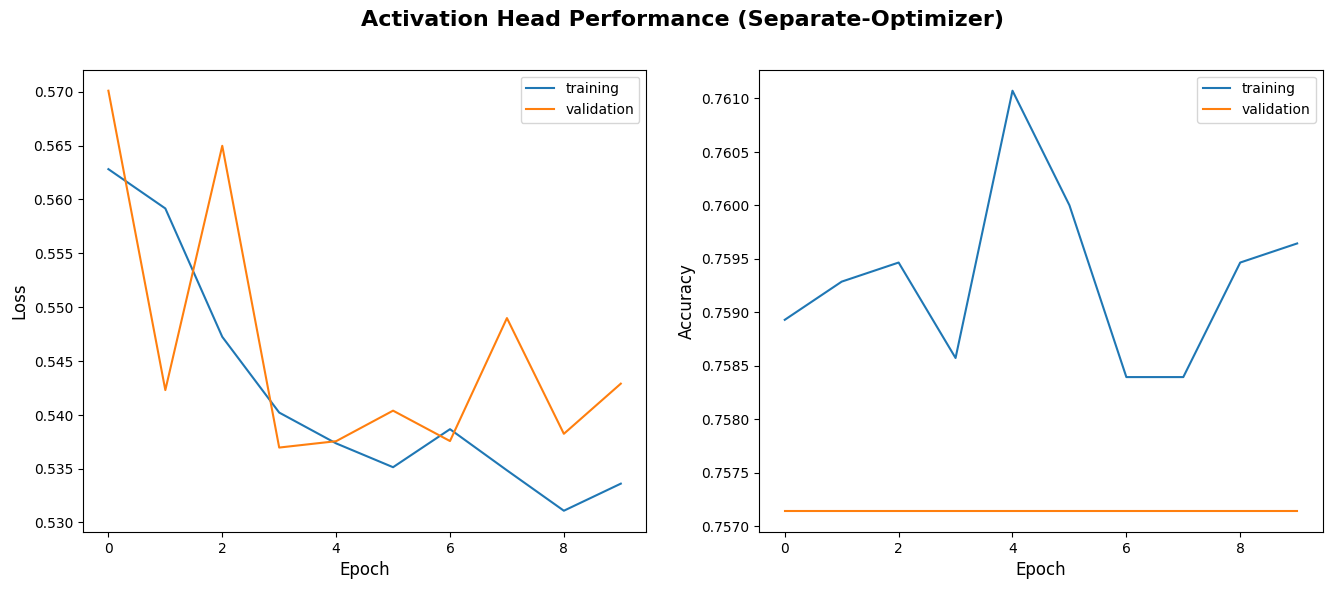

In [10]:
#print(activation_perfermace_records)
performance_plot(activation_perfermace_records, title='Activation Head Performance (Separate-Optimizer)')


### Assignment Head Performance (Separate-Optimizer)

<Figure size 640x480 with 0 Axes>

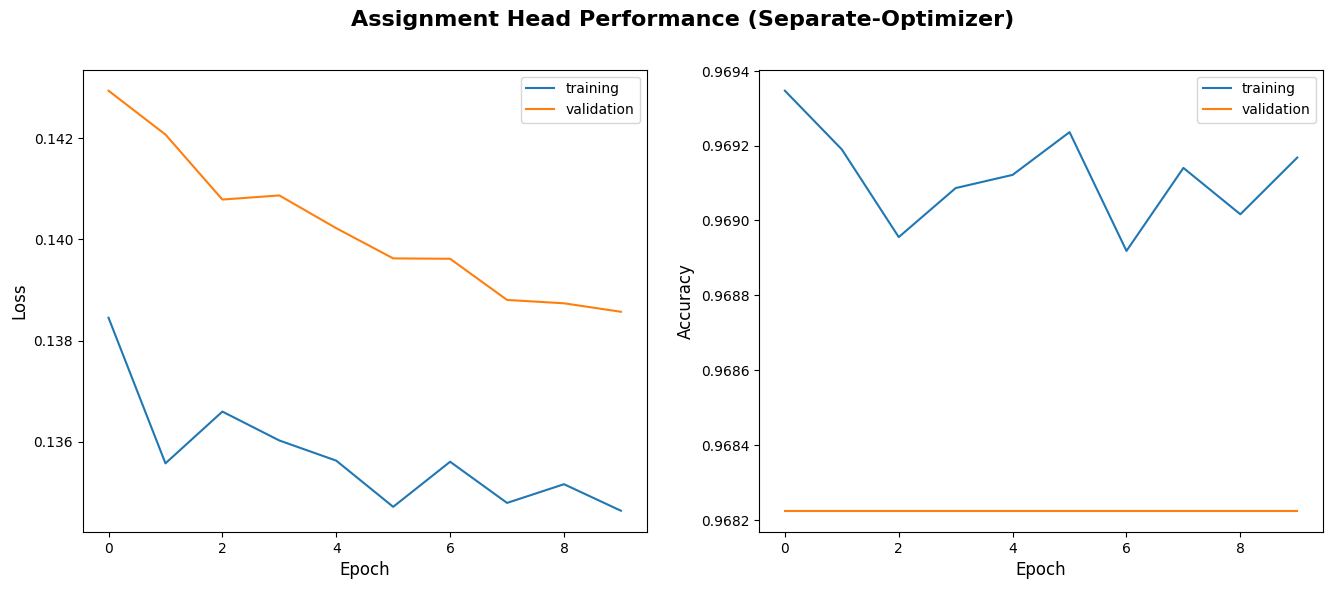

In [11]:
performance_plot(assignment_perfermace_records,title='Assignment Head Performance (Separate-Optimizer)')

### Sequencing Head Performance (Separate-Optimizer)

<Figure size 640x480 with 0 Axes>

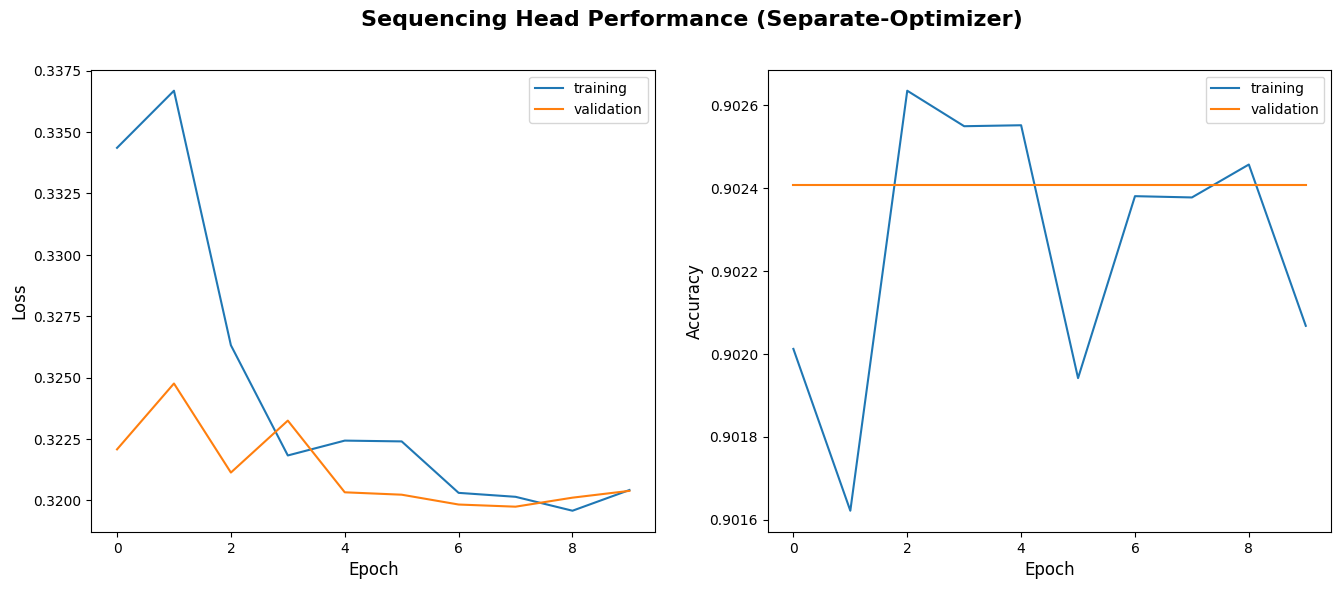

In [12]:
performance_plot(sequence_perfermace_records, title='Sequencing Head Performance (Separate-Optimizer)')